Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


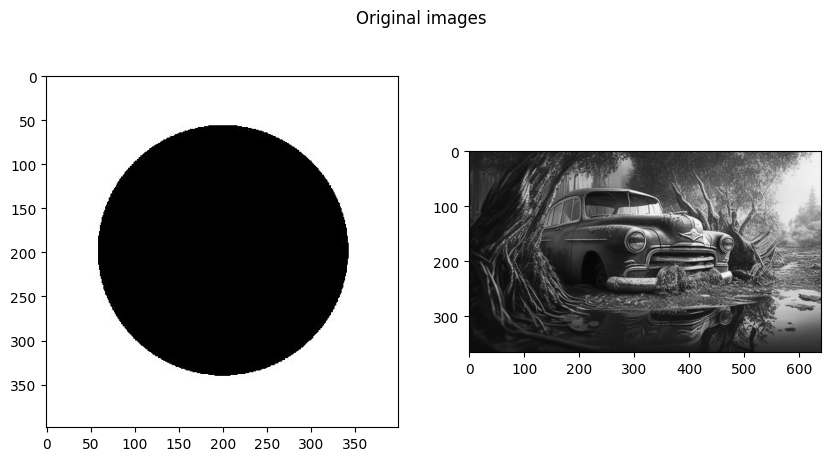

In [ ]:
import numpy as np
from numpy.typing import NDArray
from numpy.lib.stride_tricks import as_strided

import matplotlib.pyplot as plt
from google.colab import drive
import os
from skimage import io
from sklearn.metrics import mean_squared_error as MSE
import cv2

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Obrazy i sygnały')

# Images in grayscale
image = io.imread('circle.jpg', as_gray=True)
image2 = io.imread('car.jpg', as_gray=True)

# Gaussian blur kernel
kernel = np.array([[1, 2, 1],
                    [2, 4, 2],
                     [1, 2, 1]]) / 16
# Box blur
# kernel = np.array([[1, 1, 1],
#                     [1, 1, 1],
#                      [1, 1, 1]]) / 9
# Sharpen
# kernel = np.array([[0, -1, 0],
#                     [-1, 5, -1],
#                      [0, -1, 0]])

# Plot an original image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.suptitle("Original images")
ax1.imshow(image, cmap='gray')
ax2.imshow(image2, cmap='gray')

In [ ]:
# Define convolve function with strides
def convolve_avg(image: NDArray, kernel: NDArray, stride: int) -> NDArray:
  # image.shape (399, 400)
  # image.strides (3200, 8)

  img_h, img_w = image.shape
  kernel_h, kernel_w = kernel.shape

  output_shape = (
      (img_h - kernel_h) // stride + 1,
      (img_w - kernel_w) // stride + 1
  )
  output = np.zeros(output_shape)

  # Loop through entire image with given stride/step
  for i in range(0, img_h - kernel_h + 1, stride):
    for j in range(0, img_w - kernel_w + 1, stride):
      # Create kernel-size window
      window = image[i:i+kernel_h, j:j+kernel_w]
      # Take average of the window
      avg = np.mean(window)
      # Put average value into output matrix
      output[i // stride, j // stride] = avg

  return output

In [ ]:
# Define convolve function with strides
def convolve_max(image: NDArray, kernel: NDArray, stride: int) -> NDArray:
  # image.shape (399, 400)
  # image.strides (3200, 8)

  img_h, img_w = image.shape
  kernel_h, kernel_w = kernel.shape

  output_shape = (
      (img_h - kernel_h) // stride + 1,
      (img_w - kernel_w) // stride + 1
  )
  output = np.zeros(output_shape)

  # Loop through entire image with given stride/step
  for i in range(0, img_h - kernel_h + 1, stride):
    for j in range(0, img_w - kernel_w + 1, stride):
      # Create kernel-size window
      window = image[i:i+kernel_h, j:j+kernel_w]
      # Take average of the window
      max = np.max(window)
      # Put average value into output matrix
      output[i // stride, j // stride] = max

  return output

In [ ]:
# Define convolve function with strides
def convolve(image: NDArray, kernel: NDArray, stride: int) -> NDArray:
  img_h, img_w = image.shape
  kernel_h, kernel_w = kernel.shape

  output_shape = (
      (img_h - kernel_h) // stride + 1,
      (img_w - kernel_w) // stride + 1
  )
  output = np.zeros(output_shape)

  # Loop through entire image with given stride/step
  for i in range(0, img_h - kernel_h + 1, stride):
    for j in range(0, img_w - kernel_w + 1, stride):
      # Create kernel-size window
      window = image[i:i+kernel_h, j:j+kernel_w]
      # Take average of the window
      avg = np.sum(window * kernel)
      # Put average value into output matrix
      output[i // stride, j // stride] = avg

  return output

In [ ]:
# Define convolve function with strides
# Source: https://github.com/kzajac97/machine-vision/blob/main/classes/convolution/src/conv.py
def convolve_optimized(image: NDArray, kernel: NDArray, stride: int) -> NDArray:
  # image.shape (399, 400)
  # image.strides (3200, 8)

  img_h, img_w = image.shape
  kernel_h, kernel_w = kernel.shape

  output_shape = (
      (img_h - kernel_h) // stride + 1,
      (img_w - kernel_w) // stride + 1
  )

  strides = (stride * image.strides[0], stride * image.strides[1]) + image.strides
  strided_input = as_strided(image, shape=output_shape + (kernel_h, kernel_w), strides=strides)

  return np.einsum("ijkl,kl->ij", strided_input, kernel)

Convolution MSE: 0.01053372605538442
Smaller MSE: 0.014143608153582697


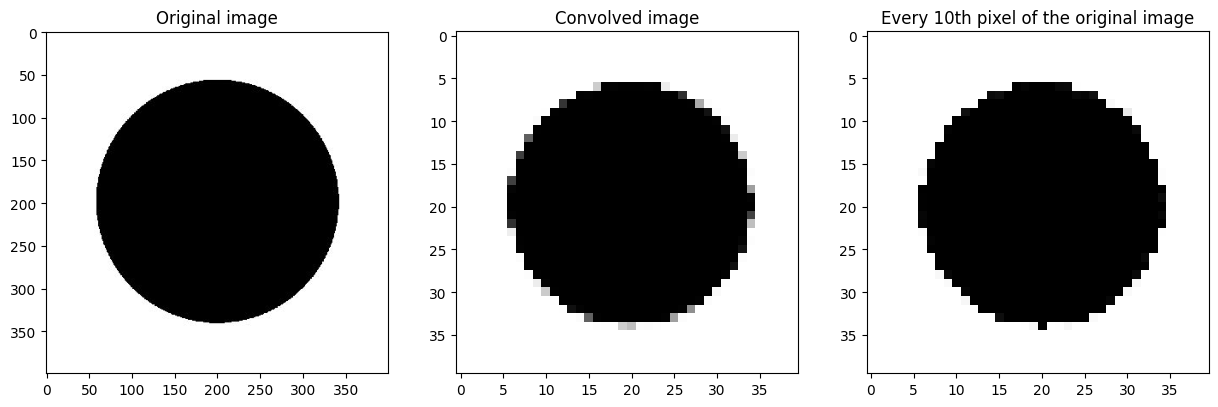

In [ ]:
# Call convolve function
stride = 10
convolved_image = convolve(image, kernel, stride)
smaller_image = image[::stride, ::stride]

# Plot convolved image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(image, cmap='gray')
ax2.set_title("Convolved image")
ax2.imshow(convolved_image, cmap='gray')
ax3.set_title(f"Every {stride}th pixel of the original image")
ax3.imshow(smaller_image, cmap='gray')

# MSE
resized_convolved_image = cv2.resize(convolved_image, (image.shape[1], image.shape[0]))
resized_convolved_optimized_image = cv2.resize(smaller_image, (image.shape[1], image.shape[0]))
convolved_error = MSE(image, resized_convolved_image)
convolved_optimized_error = MSE(image, resized_convolved_optimized_image)
print(f"Convolution MSE: {convolved_error}\nSmaller MSE: {convolved_optimized_error}")

Convolution MSE: 0.3755164444426051
Smaller MSE: 0.37705865108973596


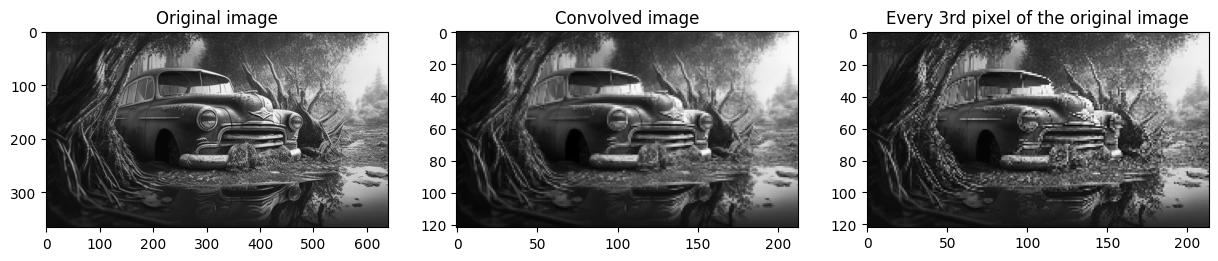

In [ ]:
# Call convolve function
stride = 3
convolved_image = convolve(image2, kernel, stride)
smaller_image = image2[::stride, ::stride]

# Plot convolved image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(image2, cmap='gray')
ax2.set_title("Convolved image")
ax2.imshow(convolved_image, cmap='gray')
ax3.set_title(f"Every {stride}rd pixel of the original image")
ax3.imshow(smaller_image, cmap='gray')

# MSE
resized_convolved_image = cv2.resize(convolved_image, (image.shape[1], image.shape[0]))
resized_convolved_optimized_image = cv2.resize(smaller_image, (image.shape[1], image.shape[0]))
convolved_error = MSE(image, resized_convolved_image)
convolved_optimized_error = MSE(image, resized_convolved_optimized_image)
print(f"Convolution MSE: {convolved_error}\nSmaller MSE: {convolved_optimized_error}")

Convolution MSE: 0.3755164444426051
Smaller MSE: 0.3755164444426051


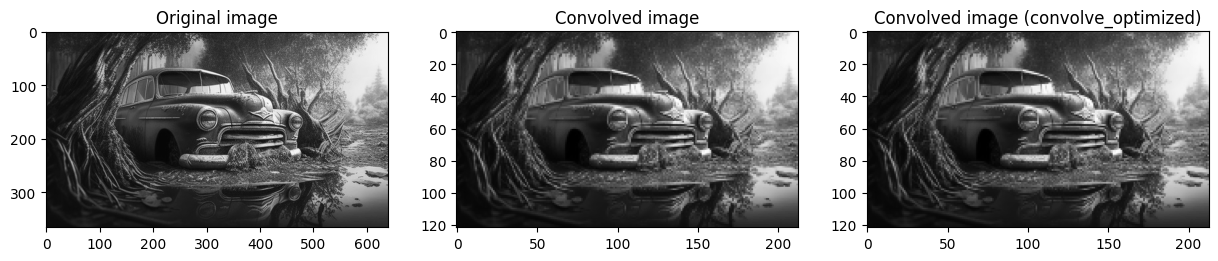

In [ ]:
# Call convolve function
stride = 3
convolved_image = convolve(image2, kernel, stride)
convolved_optimized_image = convolve_optimized(image2, kernel, stride)

# Plot convolved image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(image2, cmap='gray')
ax2.set_title("Convolved image")
ax2.imshow(convolved_image, cmap='gray')
ax3.set_title("Convolved image (convolve_optimized)")
ax3.imshow(convolved_optimized_image, cmap='gray')

# MSE
resized_convolved_image = cv2.resize(convolved_image, (image.shape[1], image.shape[0]))
resized_convolved_optimized_image = cv2.resize(convolved_optimized_image, (image.shape[1], image.shape[0]))
convolved_error = MSE(image, resized_convolved_image)
convolved_optimized_error = MSE(image, resized_convolved_optimized_image)
print(f"Convolution MSE: {convolved_error}\nSmaller MSE: {convolved_optimized_error}")

Convolution MSE: 0.3755164444426051
AVG MSE: 0.3751526504878936
MAX MSE: 0.3700112679775978


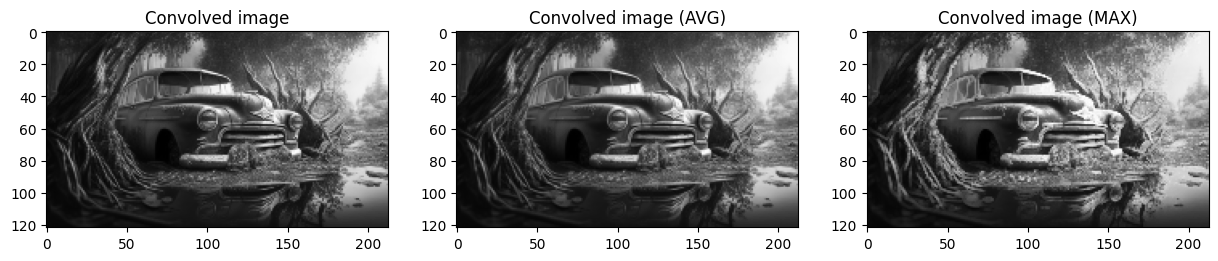

In [ ]:
# Call convolve function
stride = 3
convolved_image = convolve(image2, kernel, stride)
convolved_image_avg = convolve_avg(image2, kernel, stride)
convolved_image_max = convolve_max(image2, kernel, stride)

# Plot convolved image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Convolved image")
ax1.imshow(convolved_image, cmap='gray')
ax2.set_title("Convolved image (AVG)")
ax2.imshow(convolved_image_avg, cmap='gray')
ax3.set_title("Convolved image (MAX)")
ax3.imshow(convolved_image_max, cmap='gray')

# MSE
resized_convolved_image = cv2.resize(convolved_image, (image.shape[1], image.shape[0]))
resized_avg_image = cv2.resize(convolved_image_avg, (image.shape[1], image.shape[0]))
resized_max_optimized_image = cv2.resize(convolved_image_max, (image.shape[1], image.shape[0]))
convolved_error = MSE(image, resized_convolved_image)
convolved_avg_error = MSE(image, resized_avg_image)
convolved_max_error = MSE(image, resized_max_optimized_image)
print(f"Convolution MSE: {convolved_error}\nAVG MSE: {convolved_avg_error}\nMAX MSE: {convolved_max_error}")

In [ ]:
def h1(x):
  return np.where((x >= 0) & (x < 1), 1, 0)
def h2(x):
  return np.where((x >= -1/2) & (x < 1/2), 1, 0)
def h3(x):
  return np.where((x >= -1) & (x <= 1), 1 - np.abs(x), 0)

In [ ]:
def interpolation(image: NDArray, scale: int, h) -> NDArray:
  img_h, img_w = image.shape
  output_h, output_w = (int(img_h * scale), int(img_w * scale))
  output = np.zeros((output_h, output_w))

  for i in range(output_h):
    for j in range(output_w):
      orig_x = i / scale
      orig_y = j / scale

      x = int(orig_x)
      y = int(orig_y)

      dx = orig_x - x
      dy = orig_y - y

      if 0 <= x < img_h and 0 <= y < img_w and h(dx) > 0 and h(dy) > 0:
        output[i, j] = image[x, y]
      else:
        output[i, j] = 0

  return output

In [ ]:
def interpolation_nearest(image: NDArray, scale: int) -> NDArray:
  img_h, img_w = image.shape
  output_h, output_w = (img_h * scale, img_w * scale)

  output = np.zeros((output_h, output_w))

  for i in range(output_h):
    for j in range(output_w):
      output[i, j] = image[i // scale, j // scale]

  return output

Interpolated MSE (h1): 0.0


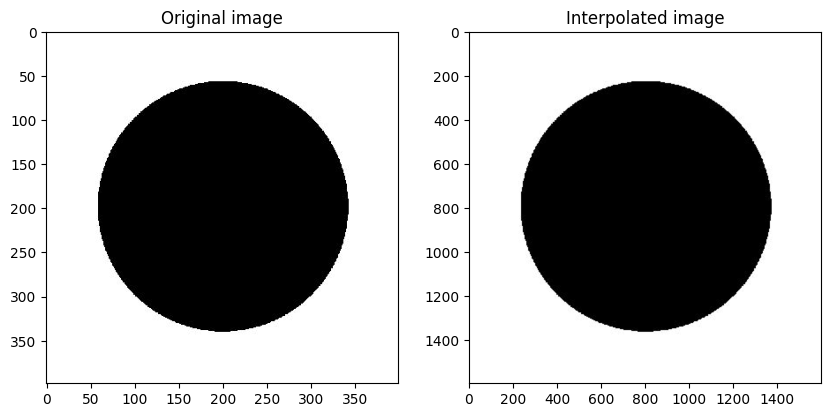

In [ ]:
# Call interpolation function
scale = 4
interpolated_image = interpolation(image, scale, h1)

# Plot convolved image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Original image")
ax1.imshow(image, cmap='gray')
ax2.set_title("Interpolated image")
ax2.imshow(interpolated_image, cmap='gray')

# MSE
resized_interpolated_image = cv2.resize(interpolated_image, (image.shape[1], image.shape[0]))
interpolated_error_h1 = MSE(image, resized_interpolated_image)
print(f"Interpolated MSE (h1): {interpolated_error_h1}")

Interpolated MSE (h1): 0.38157789445504364
Interpolated MSE (h2): 0.5081096629277254


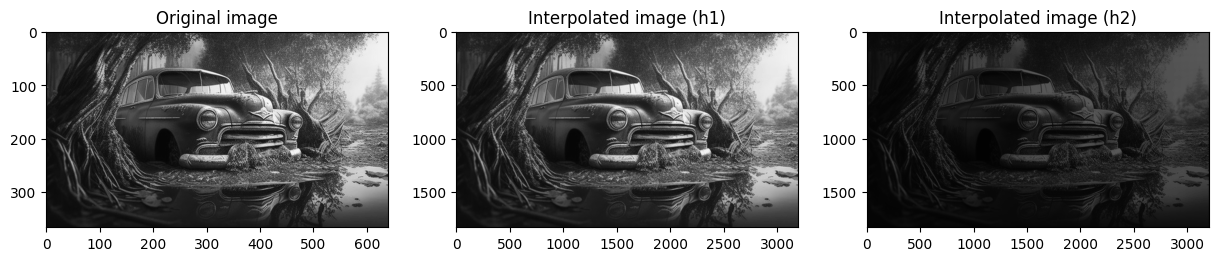

In [ ]:
# Call interpolation function
scale = 5
interpolated_image_h1 = interpolation(image2, scale, h1)
interpolated_image_h2 = interpolation(image2, scale, h2)

# Plot convolved image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(image2, cmap='gray')
ax2.set_title("Interpolated image (h1)")
ax2.imshow(interpolated_image_h1, cmap='gray')
ax3.set_title("Interpolated image (h2)")
ax3.imshow(interpolated_image_h2, cmap='gray')

# MSE
resized_interpolated_image_h1 = cv2.resize(interpolated_image_h1, (image.shape[1], image.shape[0]))
resized_interpolated_image_h2 = cv2.resize(interpolated_image_h2, (image.shape[1], image.shape[0]))
interpolated_error_h1 = MSE(image, resized_interpolated_image_h1)
interpolated_error_h2 = MSE(image, resized_interpolated_image_h2)
print(f"Interpolated MSE (h1): {interpolated_error_h1}\nInterpolated MSE (h2): {interpolated_error_h2}")